# Data Import

In [2]:
from ctypes import windll
from typing import NamedTuple

class PizzaRequest(NamedTuple):
    """
    A class to represent a raw pizza request from the dataset.
    """
    
    giver_username_if_known: str
    in_test_set: bool
    number_of_downvotes_of_request_at_retrieval: int
    number_of_upvotes_of_request_at_retrieval: int
    post_was_edited: bool
    request_id: str
    request_number_of_comments_at_retrieval: int
    request_text: str
    request_text_edit_aware: str
    request_title: str
    requester_account_age_in_days_at_request: float
    requester_account_age_in_days_at_retrieval: float
    requester_days_since_first_post_on_raop_at_request: float
    requester_days_since_first_post_on_raop_at_retrieval: float
    requester_number_of_comments_at_request: int
    requester_number_of_comments_at_retrieval: int
    requester_number_of_comments_in_raop_at_request: int
    requester_number_of_comments_in_raop_at_retrieval: int
    requester_number_of_posts_at_request: int
    requester_number_of_posts_at_retrieval: int
    requester_number_of_posts_on_raop_at_request: int
    requester_number_of_posts_on_raop_at_retrieval: int
    requester_number_of_subreddits_at_request: int
    requester_received_pizza: bool
    requester_subreddits_at_request: list[str]
    requester_upvotes_minus_downvotes_at_request: int
    requester_upvotes_minus_downvotes_at_retrieval: int
    requester_upvotes_plus_downvotes_at_request: int
    requester_upvotes_plus_downvotes_at_retrieval: int
    requester_user_flair: str
    requester_username: str
    unix_timestamp_of_request: float
    unix_timestamp_of_request_utc: float

In [3]:
import json
from pathlib import Path

def read_data(data_path) -> list[PizzaRequest]:
    """
    Read the data from the given path and return a list of PizzaRequest objects.
    :param data_path: string path to the data file relative to the current working directory
    :return: A parsed list of PizzaRequest objects
    """
    filepath = Path.cwd() / Path(data_path)

    if not filepath.exists():
        raise FileNotFoundError(
            f"File not found: {filepath}; " +
            f"Current working directory: {Path.cwd()}; " +
            f"Relative path to data file: {Path(data_path)}"
        )

    print(f"Using file: {filepath.absolute()}")

    with filepath.open("r", encoding="UTF-8") as file:
        raw_data = json.load(file)
        # Turn loaded dict into a list of PizzaRequest objects
        return [
            PizzaRequest(**datapoint)
            for datapoint
            in raw_data
        ]


## Load the data creating the graph

In [4]:
## CAPITALIZED because they are 'constants' which shouldn't be reassigned

# load the data
RAW_DATA = read_data("./dataset/pizza_request_dataset.json")

# create a pandas dataframe
import pandas as pd
DATAFRAME = pd.DataFrame(RAW_DATA)

# use requester_username and giver_username_if_known to create a networkx graph
import networkx as nx
GRAPH = nx.DiGraph()

# create a set of usernames for both requester and giver
usernames = set()
usernames.add(row.requester_username for row in RAW_DATA)
usernames.add(row.giver_username_if_known for row in RAW_DATA)

# delete None values
usernames.discard(None)

# add nodes to the graph
GRAPH.add_nodes_from(usernames)

# add edges between requester and giver
GRAPH.add_edges_from(
    (row.giver_username_if_known, row.requester_username)
    for row in RAW_DATA
    if row.giver_username_if_known is not None
)

Using file: C:\Users\majerm\projects\private\github\rug-sna-pizza-giving\dataset\pizza_request_dataset.json


# Data Exploration

In [5]:
# print the number of nodes and edges
print(f"Number of nodes: {GRAPH.number_of_nodes()}")
print(f"Number of edges: {GRAPH.number_of_edges()}")

Number of nodes: 5999
Number of edges: 5671


In [6]:
# Group the data by givers, and sort by those who gave the most pizzas
(DATAFRAME.groupby("giver_username_if_known")
 .size()
 .sort_values(ascending=False)
 .head(10))

giver_username_if_known
N/A                5271
pastafariantwit       7
jetboyterp            6
johngalt1337          6
m2nu                  6
mr_jeep               5
thr                   5
tanyagal2             4
harrisonfire          4
incoherentrant        3
dtype: int64

In [7]:
# Group the data by requesters, and sort by those who received the most pizzas
(DATAFRAME.groupby("requester_username")
 .size()
 .sort_values(ascending=False)
 .head(10))

requester_username
zzisrafelzz           1
-Magitek-Armor-       1
-idk                  1
-notagirl-            1
0110110101101100      1
0b4m4                 1
0o00o00o0o00o0oooO    1
yun-                  1
yungbroccoli          1
yupitsaslie           1
dtype: int64

> *You can request at most a single pizza, but you can give multiple pizzas*
> 
> pastafariantwit gave 7 pizzas, and everyone received at most 1 pizza

Size of givers: 4
Size of requestors: 25


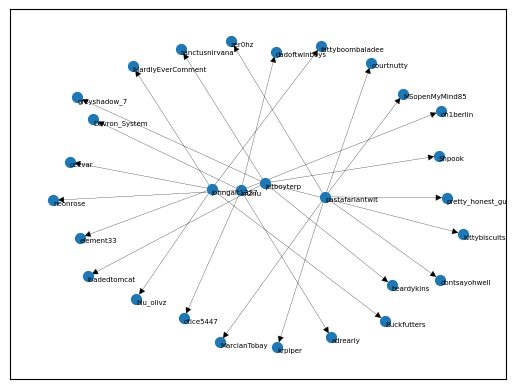

In [35]:
# Draw the graph
import matplotlib.pyplot as plt 
# nx.draw(GRAPH, with_labels=False, font_weight='bold')

# Draw only nodes with more than 5 out degree along with the edges and nodes connected to them

givers = set(
    node for node in GRAPH.nodes
    if 5 < GRAPH.out_degree(node) < 100
)

print(f"Size of givers: {len(givers)}")

# flatmap the successors of the givers
requestors = set(
    successor for giver in givers
    for successor in GRAPH.successors(giver)
)


print(f"Size of requestors: {len(requestors)}")


subgraph = GRAPH.subgraph(givers | requestors)
# subgraph = GRAPH.subgraph(max(nx.weakly_connected_components(GRAPH), key=len))

# nx_opts = {
#     'node_color': 'black',
#     'node_size': 3,
#     'width': 1,
# }


# Drawing keywords: https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
nx.draw_networkx(
    subgraph, 
    node_size=50, 
    width=.2, 
    with_labels=True, 
    font_size=5, 
    horizontalalignment='left', 
    verticalalignment='top'
)

# Algorithms: https://networkx.org/documentation/stable/reference/algorithms/index.html